# Import Packages

In [1]:
!pip install torchsummary

In [2]:
import pydicom
import pandas as pd
import numpy as np
import random
from collections import Counter, defaultdict

import matplotlib.pyplot as plt
import plotly.express as px

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset, Subset, DataLoader
from torchvision.transforms import v2
import torchvision.models as models # VGG16, ResNet50
from torchsummary import summary # summary for models
from torch.utils.tensorboard import SummaryWriter

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

/opt/conda/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https:/

# Configuration

In [3]:
class config:
    
    root = "/kaggle/input/dlmia2/hwk02_data"
    valid_prob = 0.3
    batch_size = 16
    lr = 6e-4
    epochs = 180
    weight_decay = 4e-4
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    seed = 42
    
print(config.device)

cuda


# Input Data

In [4]:
train_data = pd.read_csv('/kaggle/input/dlmia2/hwk02_data/train.csv')
test_data = pd.read_csv('/kaggle/input/dlmia2/hwk02_data/test.csv')
print(f'Number of training samples: {train_data.shape[0]}')
print(f'Number of testing samples: {test_data.shape[0]}')

Number of training samples: 161
Number of testing samples: 41


# Defined functions

In [5]:
def seed_everything(seed):
    # Set Python random seed
    random.seed(seed)
    
    # Set NumPy random seed
    np.random.seed(seed)
    
    # Set PyTorch random seed for CPU and GPU
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    
    # Set PyTorch deterministic operations for cudnn backend
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def evaluator(preds, gts):
    preds = preds.cpu().numpy() if isinstance(preds, torch.Tensor) else preds
    gts = gts.cpu().numpy() if isinstance(gts, torch.Tensor) else gts
    acc = accuracy_score(preds, gts)
    f1 = f1_score(preds, gts, average="macro")

    return acc, f1

def train_one_epoch(model, train_loader, optimizer, scheduler, criterion, device):
    model.train()
    train_loss = .0
    predictions, ground_truths = [], []
    for images, ages, genders, labels in train_loader:
        images = images.to(device=device, dtype=torch.float)
        ages = ages.to(device=device, dtype=torch.float)
        genders = genders.to(device=device, dtype=torch.float)
        labels = labels.to(device=device, dtype=torch.long)

        optimizer.zero_grad()
        logits = model(images, ages, genders)
        labels = torch.sub(labels, 1) # labels 1, 2, 3 -> 0, 1, 2
        loss = criterion(logits, labels)
        loss.backward()

        optimizer.step()
        scheduler.step()

        train_loss += loss.item()
        preds = torch.argmax(logits, dim=1)

        predictions.append(preds)
        ground_truths.append(labels)

    train_loss /= len(train_loader)

    predictions = torch.cat(predictions)
    ground_truths = torch.cat(ground_truths)
    train_acc, train_f1 = evaluator(predictions, ground_truths)

    return train_loss, 100*train_acc, 100*train_f1

def validation(model, valid_loader, criterion, device):
    model.eval()
    valid_loss = .0
    predictions, ground_truths = [], []
    with torch.no_grad():
        for images, ages, genders, labels in valid_loader:
            images = images.to(device=device, dtype=torch.float)
            ages = ages.to(device=device, dtype=torch.float)
            genders = genders.to(device=device, dtype=torch.float)
            labels = labels.to(device=device, dtype=torch.long)

            logits = model(images, ages, genders)
            labels = torch.sub(labels, 1) # labels 1, 2, 3 -> 0, 1, 2
            loss = criterion(logits, labels)

            valid_loss += loss.item()
            preds = torch.argmax(logits, dim=1)

            predictions.append(preds)
            ground_truths.append(labels)

        valid_loss /= len(valid_loader)

        predictions = torch.cat(predictions)
        ground_truths = torch.cat(ground_truths)
        valid_acc, valid_f1 = evaluator(predictions, ground_truths)
    return valid_loss, 100*valid_acc, 100*valid_f1

# Defined Dataset

In [6]:
class ParkinsonsDataset(Dataset):
    def __init__(self, df, transforms = None): # 將所有資料提出
        self.ages = np.array(df['Age']) # 年齡
        self.genders = np.array(df['Gender']) # 性別
        self.labels = np.array(df['Stage']) # 標籤
        self.indexs = np.array(df['index']) # 起始張數
        self.paths = np.array(df['FilePath']) # 影像路徑
        self.images = []

        # 影像前處理
        for index, path in zip(self.indexs, self.paths):
            image = pydicom.dcmread(config.root+path).pixel_array
            image = torch.tensor(image.astype(np.float32))
            image = image[index-1:index+2, :, :] # 取指定張數和前後共三個, image size = (3, 128, 128)
            if transforms:
                image = transforms(image)
            self.images.append(image)


    def __len__(self):
        return len(self.labels) # label數量

    def __getitem__(self, idx): # 找出指定的資料
        age = torch.tensor(self.ages[idx], dtype=torch.float32)
        gender = torch.tensor(self.genders[idx], dtype=torch.float32)
        label = self.labels[idx]
        image = self.images[idx]

        return image, age, gender, label

# Transformation
class My_normalize(object): # 自定義的類別
    # def __init__(self): # 宣告此類別中會使用到的變數

    def __call__(self, image): # 定義有image之後要進行的資料處理
        new_image = (image - image.mean())/(image.max() - image.min())

        return new_image

My_transforms = v2.Compose([
    # 在v2中內建的func
    v2.CenterCrop(size = (50, 50)),
    # 自定義的func
    My_normalize()
])

# Redefined VGG16

In [7]:
class VGGplus(nn.Module):
    def __init__(self, num_classes, input_size = (3, 50, 50), out_prob = True, features_grad = False): # 默認輸出為分到每一類的機率
        super().__init__()
        
        # 決定是否要將輸出轉換為機率
        self.out_prob = out_prob
        
        # 取出vgg16中的特徵層
        vgg16 = models.vgg16(weights='IMAGENET1K_V1', progress = True)
        vgg16.features[30] = nn.Identity()
        vgg16.avgpool = nn.AdaptiveAvgPool2d(1)
        vgg16.classifier = nn.Identity()
        
        # 固定/不固定特徵層的參數值
        for param in vgg16.features.parameters():
            param.requires_grad = features_grad
        self.backend = vgg16
         
        # 增加分類層
        self.classifier = nn.Sequential(
          nn.Linear(514, num_classes) # 512: vgg16特徵層結果, 2: age & gender
        )
        self.softmax = nn.Softmax(dim=1) # 每一個row的總和都是1

    def forward(self, x, age, gender):
        output = self.backend(x)
        outputs = torch.cat([output, age.view(-1, 1), gender.view(-1, 1)], dim = 1) # output size = (batch_size, 512), age size = (batch_size), age.view(-1, 1) size = (batch_size, 1), dim = 1; columns concat
        outputs = self.classifier(outputs) # outputs size = (batch_size, 3)
        if self.out_prob:
            outputs = self.softmax(outputs)
        return outputs

Initializing dataset...
Number of samples in train_dataset: Counter({3: 54, 2: 30, 1: 29})
Number of samples in val_dataset: Counter({3: 21, 1: 15, 2: 12})
Initializing model...


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 272MB/s]


Epoch[1/180], Train Loss: 1.0806, Train Accuracy: 46.90%, Train F1: 31.00% | Valid Loss: 1.0530, Valid Accuracy: 43.75%, Valid F1: 20.29% | LR: 0.000024
Epoch[2/180], Train Loss: 1.0468, Train Accuracy: 47.79%, Train F1: 21.56% | Valid Loss: 1.0181, Valid Accuracy: 45.83%, Valid F1: 24.75% | LR: 0.000026
Epoch[3/180], Train Loss: 1.0158, Train Accuracy: 53.98%, Train F1: 37.16% | Valid Loss: 0.9770, Valid Accuracy: 62.50%, Valid F1: 46.91% | LR: 0.000028
Epoch[4/180], Train Loss: 1.0044, Train Accuracy: 59.29%, Train F1: 43.70% | Valid Loss: 0.9381, Valid Accuracy: 66.67%, Valid F1: 50.61% | LR: 0.000032
Epoch[5/180], Train Loss: 0.8988, Train Accuracy: 62.83%, Train F1: 47.00% | Valid Loss: 0.9080, Valid Accuracy: 70.83%, Valid F1: 53.88% | LR: 0.000036
Epoch[6/180], Train Loss: 0.9040, Train Accuracy: 61.95%, Train F1: 46.48% | Valid Loss: 0.8818, Valid Accuracy: 66.67%, Valid F1: 50.60% | LR: 0.000041
Epoch[7/180], Train Loss: 0.9654, Train Accuracy: 63.72%, Train F1: 47.86% | Valid

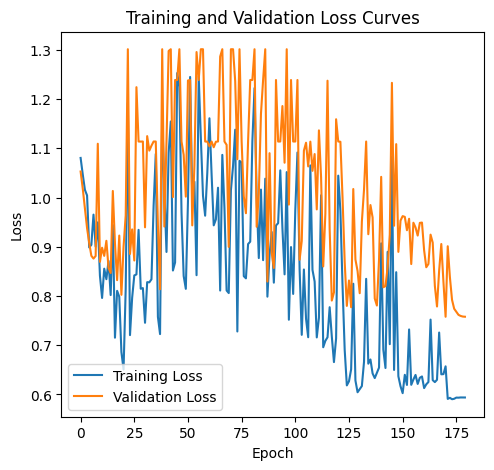

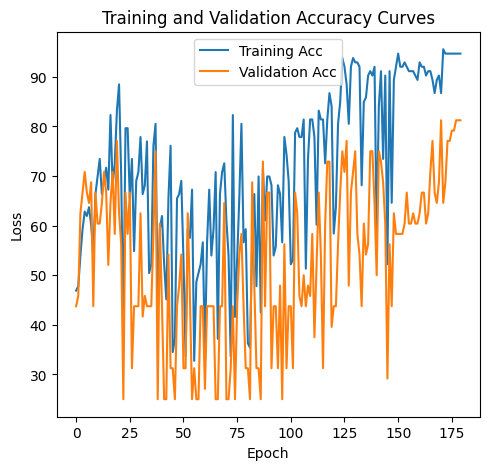

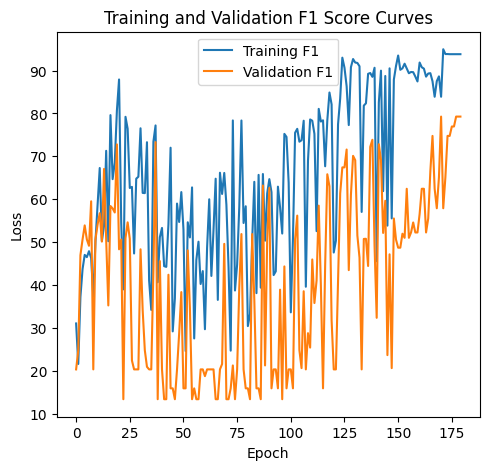

In [8]:
def main():

    seed_everything(config.seed)

    # train & test dataframe
    train_df = pd.read_csv('/kaggle/input/dlmia2/hwk02_data/train.csv')
    # test_df = pd.read_csv(config.root+'/data/test.csv')

    # Dataset
    print("Initializing dataset...")
    dataset = ParkinsonsDataset(train_df, transforms = My_transforms)
#     print("Initializing test_dataset...")
#     test_dataset = ParkinsonsDataset(test_df, transforms = My_transforms)
    
    # split training & validation dataset 
    n = len(dataset)
    valid_size = int(n * config.valid_prob)
    train_ids , valid_ids = train_test_split(
     np.linspace(0, n - 1, n).astype("int"),
     test_size = valid_size,
     random_state = config.seed,
    )
    print(f'Number of samples in train_dataset: {Counter(dataset.labels[train_ids])}')
    print(f'Number of samples in val_dataset: {Counter(dataset.labels[valid_ids])}')
    
    # DataLoader
    train_dataset = Subset(dataset, train_ids)
    valid_dataset = Subset(dataset, valid_ids)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=config.batch_size, shuffle=False)
    # test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False)

    # settings
    print("Initializing model...")
    num_classes = len(Counter(dataset.labels[train_ids]))
    model = VGGplus(num_classes = num_classes, features_grad = True)
    model.to(config.device)
    criterion = nn.CrossEntropyLoss().to(config.device)
    optimizer = torch.optim.Adam(model.parameters(), lr = config.lr, weight_decay = config.weight_decay)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer = optimizer,
        epochs = config.epochs,
        steps_per_epoch = train_loader.__len__(),
        max_lr = config.lr,
        anneal_strategy = 'cos'
    )

    # recordings
    best_val_loss = float("inf")
    history = {
      "train": {
          "loss": [],
          "acc": [],
          "f1": []
      },
      "valid": {
          "loss": [],
          "acc": [],
          "f1": []
      },
    }

    for epoch in range(config.epochs):
        train_loss, train_acc, train_f1 = train_one_epoch(model, train_loader, optimizer, scheduler, criterion, config.device)
        valid_loss, valid_acc, valid_f1 = validation(model, valid_loader, criterion, config.device)
        
        # Log the loss and validation result
        history["train"]["loss"].append(train_loss)
        history["train"]["acc"].append(train_acc)
        history["train"]["f1"].append(train_f1)
        history["valid"]["loss"].append(valid_loss)
        history["valid"]["acc"].append(valid_acc)
        history["valid"]["f1"].append(valid_f1)

        print(f'Epoch[{epoch+1}/{config.epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%, Train F1: {train_f1:.2f}% | Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_acc:.2f}%, Valid F1: {valid_f1:.2f}% | LR: {optimizer.state_dict()["param_groups"][0]["lr"]:.6f}')

        if valid_loss < best_val_loss:
            save_file = {
                "model": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "scheduler": scheduler.state_dict(),
                "epoch": epoch,
                "args": config
            }
            best_val_loss = valid_loss
            torch.save(save_file, "checkpoint.pth")

        best_ckpt = torch.load("checkpoint.pth", map_location=config.device)
        model.load_state_dict(best_ckpt["model"])

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(config.epochs), history["train"]["loss"], label='Training Loss')
    plt.plot(range(config.epochs), history["valid"]["loss"], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss Curves')
    plt.show()

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(config.epochs), history["train"]["acc"], label='Training Acc')
    plt.plot(range(config.epochs), history["valid"]["acc"], label='Validation Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Accuracy Curves')
    plt.show()

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(config.epochs), history["train"]["f1"], label='Training F1')
    plt.plot(range(config.epochs), history["valid"]["f1"], label='Validation F1')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation F1 Score Curves')
    plt.show()

if __name__ == "__main__":
    main()

# predict

In [9]:
# Pytorch Dataset
class ParkinsonsDataset_test(Dataset):
    def __init__(self, df, transforms = None): # 將所有資料提出
        self.ages = np.array(df['Age']) # 年齡
        self.genders = np.array(df['Gender']) # 性別
        self.indexs = np.array(df['index']) # 起始張數
        self.paths = np.array(df['FilePath']) # 影像路徑
        self.images = []

        # 影像前處理
        for index, path in zip(self.indexs, self.paths):
            image = pydicom.dcmread(config.root+path).pixel_array
            image = torch.tensor(image.astype(np.float32))
            image = image[index-1:index+2, :, :] # 取指定張數和前後共三個, image size = (3, 128, 128)
            if transforms:
                image = transforms(image)
            self.images.append(image)


    def __len__(self):
        return len(self.ages) # label數量

    def __getitem__(self, idx): # 找出指定的資料
        age = torch.tensor(self.ages[idx], dtype=torch.float32)
        gender = torch.tensor(self.genders[idx], dtype=torch.float32)
        image = self.images[idx]

        return image, age, gender, 

# Transformation
class My_normalize(object): # 自定義的類別
    # def __init__(self): # 宣告此類別中會使用到的變數

    def __call__(self, image): # 定義有image之後要進行的資料處理
        new_image = (image - image.mean())/(image.max() - image.min())

        return new_image

My_transforms = v2.Compose([
    # 在v2中內建的func
    v2.CenterCrop(size = (50, 50)),
    # 自定義的func
    My_normalize()
])


# Pytorch DataLoader
test_dataset = ParkinsonsDataset_test(test_data,transforms = My_transforms)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False)

# predict test data
device = config.device

def test(model, test_loader, device):
    model.to('cuda') # 將模型移動到GPU(原本是會出現模型和數據在不同地方的error)
    model.eval()   # 預測模式
    predictions = []
    prob = []
    with torch.no_grad():
        for images, ages, genders in test_loader:
            images = images.to(device=device, dtype=torch.float)
            ages = ages.to(device=device, dtype=torch.float)
            genders = genders.to(device=device, dtype=torch.float)

            logits = model(images, ages, genders)
            
            probs = logits.softmax(dim=1)
            preds = torch.argmax(logits, dim=1)
            
            
            predictions.append(preds)
            prob.append(probs)
            
    predictions = torch.cat(predictions,dim=0)   
    prob = torch.cat(prob,dim=0)
    
    return predictions,prob

model = VGGplus(num_classes=3)
state_dict = torch.load("checkpoint.pth") # 把剛剛的模型載入
model.load_state_dict(state_dict["model"]) # 把模型中的state_dict加載進來

pred ,p = test(model, test_loader, device) #用此model去做預測

pred_array = pred.cpu().numpy() # 因為是原本在GPU的數組，所以要加.cpu()
p_array = p.cpu().numpy()

# 將預測結果輸出

In [10]:
a = {}
for i in range(3):
    a[f"Stage {i+1}"] = p_array[:,i]

df = pd.DataFrame(a)
df["Stage"] = pred_array+1


df_VGG16 = pd.read_csv('/kaggle/input/dlmia2/hwk02_data/test.csv')
df_VGG16[df.columns] = df

df_VGG16.to_csv('VGG16.csv',index = False)
df_VGG16.head()


,ID,Age,Gender,FilePath,index,Stage 1,Stage 2,Stage 3,Stage
0,A152206,64,1,/DICOM/A152206/00010023,11,0.575625,0.212308,0.212067,1
1,A42278,72,1,/DICOM/A42278/00010022,10,0.212370,0.575137,0.212494,2
2,A306881,89,0,/DICOM/A306881/00010033,19,0.214553,0.222062,0.563385,3
3,A289458,44,0,/DICOM/A289458/00010035,16,0.211942,0.211943,0.576115,3
4,A518725,72,0,/DICOM/A518725/00010022,9,0.556637,0.227330,0.216032,1


# dataset

In [11]:
class ParkinsonsDataset(Dataset):
    def __init__(self, df, transforms = None): # 將所有資料提出
        self.ages = np.array(df['Age']) # 年齡
        self.genders = np.array(df['Gender']) # 性別
        self.labels = np.array(df['Stage']) # 標籤
        self.indexs = np.array(df['index']) # 起始張數
        self.paths = np.array(df['FilePath']) # 影像路徑
        self.images = []

        # 影像前處理
        for index, path in zip(self.indexs, self.paths):
            image = pydicom.dcmread(config.root+path).pixel_array
            image = torch.tensor(image.astype(np.float32))
            image = image[index-1:index+2, :, :] # 取指定張數和前後共三個, image size = (3, 128, 128)
            if transforms:
                image = transforms(image)
            self.images.append(image)


    def __len__(self):
        return len(self.labels) # label數量

    def __getitem__(self, idx): # 找出指定的資料
        age = torch.tensor(self.ages[idx], dtype=torch.float32)
        gender = torch.tensor(self.genders[idx], dtype=torch.float32)
        label = self.labels[idx]
        image = self.images[idx]

        return image, age, gender, label

# Transformation
class My_normalize(object): # 自定義的類別
    # def __init__(self): # 宣告此類別中會使用到的變數

    def __call__(self, image): # 定義有image之後要進行的資料處理
        new_image = (image - image.mean())/(image.max() - image.min())

        return new_image

My_transforms = v2.Compose([
    # 在v2中內建的func
    v2.CenterCrop(size = (50, 50)),
    # 自定義的func
    My_normalize()
])

# ResNet50_config

In [12]:
class config:
    
    root = "/kaggle/input/dlmia2/hwk02_data"
    valid_prob = 0.3
    batch_size = 16
    lr = 2e-4
    epochs = 160
    weight_decay = 1e-4
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    seed = 42

# ResNet50

In [13]:
class ResNet50Plus(nn.Module):
    def __init__(self, num_classes, input_size=(3, 50, 50), out_prob=True, features_grad=False):
        super(ResNet50Plus, self).__init__()

        # 決定是否要將輸出轉換為機率
        self.out_prob = out_prob

        # 取出ResNet50中的特徵層
        resnet50 = models.resnet50(pretrained=True)
        # 去掉ResNet50的最後兩層（全局平均池化和全連接層）
#         resnet50 = nn.Sequential(*list(resnet50.children())[:-2])

        # 固定/不固定特徵層的參數值
        for param in resnet50.parameters():
            param.requires_grad = features_grad
        self.backend = resnet50

        # 增加分類層
        self.classifier = nn.Sequential(
#             nn.AdaptiveAvgPool2d(1),
#             nn.Flatten(start_dim=1),
            nn.Linear(1000+2, num_classes)  # 1000: ResNet50特徵層結果, 2: age & gender
        )
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x, age, gender):
        output = self.backend(x)
        outputs = torch.cat([output.view(output.size(0), -1), age.view(-1, 1), gender.view(-1, 1)], dim=1)
        outputs = self.classifier(outputs)
        if self.out_prob:
            outputs = self.softmax(outputs)
        return outputs

#     def forward(self, x, age, gender):
#         output = self.backend(x)
#         print("Backend output shape:", output.shape)

#         output = output.view(output.size(0), -1)
#         print("Flattened output shape:", output.shape)

#         outputs = torch.cat([output, age.view(-1, 1), gender.view(-1, 1)], dim=1)
#         print("Concatenated input shape:", outputs.shape)

#         outputs = self.classifier(outputs)
#         if self.out_prob:
#             outputs = self.softmax(outputs)

#         print("Final output shape:", outputs.shape)
#         return outputs

Initializing dataset...
Number of samples in train_dataset: Counter({3: 54, 2: 30, 1: 29})
Number of samples in val_dataset: Counter({3: 21, 1: 15, 2: 12})
Initializing model...


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 213MB/s]


Epoch[1/160], Train Loss: 1.0809, Train Accuracy: 31.86%, Train F1: 23.78% | Valid Loss: 1.0646, Valid Accuracy: 43.75%, Valid F1: 21.21% | LR: 0.000008
Epoch[2/160], Train Loss: 0.9921, Train Accuracy: 55.75%, Train F1: 49.28% | Valid Loss: 1.0884, Valid Accuracy: 39.58%, Valid F1: 39.72% | LR: 0.000009
Epoch[3/160], Train Loss: 1.0309, Train Accuracy: 50.44%, Train F1: 43.43% | Valid Loss: 1.0865, Valid Accuracy: 37.50%, Valid F1: 37.36% | LR: 0.000010
Epoch[4/160], Train Loss: 0.9941, Train Accuracy: 49.56%, Train F1: 41.19% | Valid Loss: 1.1197, Valid Accuracy: 35.42%, Valid F1: 34.24% | LR: 0.000011
Epoch[5/160], Train Loss: 1.0257, Train Accuracy: 50.44%, Train F1: 41.45% | Valid Loss: 1.1016, Valid Accuracy: 35.42%, Valid F1: 35.22% | LR: 0.000013
Epoch[6/160], Train Loss: 1.0210, Train Accuracy: 49.56%, Train F1: 40.96% | Valid Loss: 1.1310, Valid Accuracy: 33.33%, Valid F1: 31.51% | LR: 0.000015
Epoch[7/160], Train Loss: 0.9632, Train Accuracy: 55.75%, Train F1: 47.27% | Valid

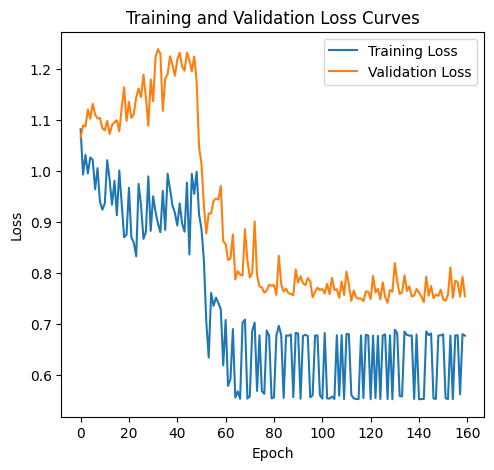

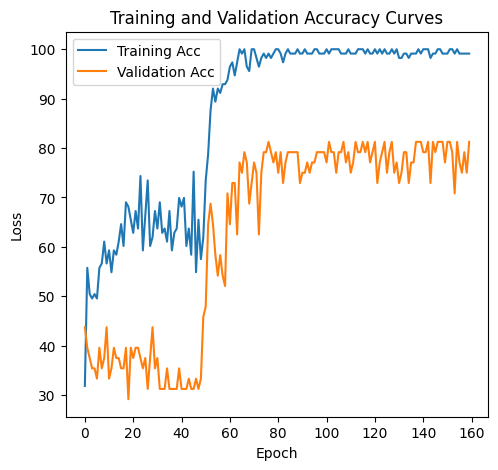

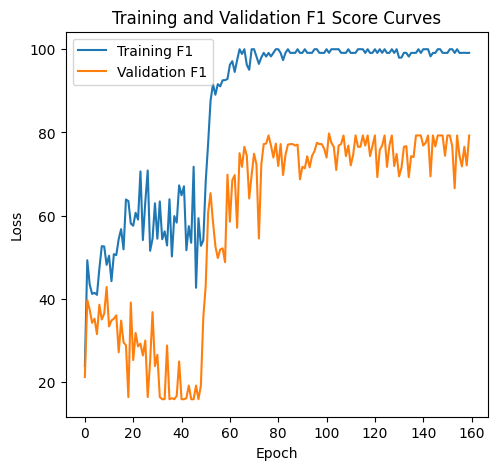

In [14]:
def main():

    seed_everything(config.seed)

    # train & test dataframe
    train_df = pd.read_csv('/kaggle/input/dlmia2/hwk02_data/train.csv')
    # test_df = pd.read_csv(config.root+'/data/test.csv')

    # Dataset
    print("Initializing dataset...")
    dataset = ParkinsonsDataset(train_df, transforms = My_transforms)
#     print("Initializing test_dataset...")
#     test_dataset = ParkinsonsDataset(test_df, transforms = My_transforms)
    
    # split training & validation dataset 
    n = len(dataset)
    valid_size = int(n * config.valid_prob)
    train_ids , valid_ids = train_test_split(
     np.linspace(0, n - 1, n).astype("int"),
     test_size = valid_size,
     random_state = config.seed,
    )
    print(f'Number of samples in train_dataset: {Counter(dataset.labels[train_ids])}')
    print(f'Number of samples in val_dataset: {Counter(dataset.labels[valid_ids])}')
    
    # DataLoader
    train_dataset = Subset(dataset, train_ids)
    valid_dataset = Subset(dataset, valid_ids)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=config.batch_size, shuffle=False)
    # test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False)

    # settings
    print("Initializing model...")
    num_classes = len(Counter(dataset.labels[train_ids]))
    model = ResNet50Plus(num_classes = num_classes, features_grad = True)
    model.to(config.device)
    criterion = nn.CrossEntropyLoss().to(config.device)
    optimizer = torch.optim.Adam(model.parameters(), lr = config.lr, weight_decay = config.weight_decay)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer = optimizer,
        epochs = config.epochs,
        steps_per_epoch = train_loader.__len__(),
        max_lr = config.lr,
        anneal_strategy = 'cos'
    )

    # recordings
    best_val_loss = float("inf")
    history = {
      "train": {
          "loss": [],
          "acc": [],
          "f1": []
      },
      "valid": {
          "loss": [],
          "acc": [],
          "f1": []
      },
    }

    for epoch in range(config.epochs):
        train_loss, train_acc, train_f1 = train_one_epoch(model, train_loader, optimizer, scheduler, criterion, config.device)
        valid_loss, valid_acc, valid_f1 = validation(model, valid_loader, criterion, config.device)
        
        # Log the loss and validation result
        history["train"]["loss"].append(train_loss)
        history["train"]["acc"].append(train_acc)
        history["train"]["f1"].append(train_f1)
        history["valid"]["loss"].append(valid_loss)
        history["valid"]["acc"].append(valid_acc)
        history["valid"]["f1"].append(valid_f1)

        print(f'Epoch[{epoch+1}/{config.epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%, Train F1: {train_f1:.2f}% | Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_acc:.2f}%, Valid F1: {valid_f1:.2f}% | LR: {optimizer.state_dict()["param_groups"][0]["lr"]:.6f}')

        if valid_loss < best_val_loss:
            save_file = {
                "model": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "scheduler": scheduler.state_dict(),
                "epoch": epoch,
                "args": config
            }
            best_val_loss = valid_loss
            torch.save(save_file, "checkpoint_2.pth")

        best_ckpt = torch.load("checkpoint_2.pth", map_location=config.device)
        model.load_state_dict(best_ckpt["model"])

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(config.epochs), history["train"]["loss"], label='Training Loss')
    plt.plot(range(config.epochs), history["valid"]["loss"], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss Curves')
    plt.show()

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(config.epochs), history["train"]["acc"], label='Training Acc')
    plt.plot(range(config.epochs), history["valid"]["acc"], label='Validation Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Accuracy Curves')
    plt.show()

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(config.epochs), history["train"]["f1"], label='Training F1')
    plt.plot(range(config.epochs), history["valid"]["f1"], label='Validation F1')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation F1 Score Curves')
    plt.show()

if __name__ == "__main__":
    main()

# predict

In [15]:
# Pytorch DataLoader
test_dataset = ParkinsonsDataset_test(test_data,transforms = My_transforms)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False)

# predict test data
device = config.device

model = ResNet50Plus(num_classes=3)
state_dict = torch.load("checkpoint_2.pth") # 把剛剛的模型載入
model.load_state_dict(state_dict["model"]) # 把模型中的state_dict加載進來

pred ,p = test(model, test_loader, device) #用此model去做預測

pred_array = pred.cpu().numpy() # 因為是原本在GPU的數組，所以要加.cpu()
p_array = p.cpu().numpy()

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [16]:
a = {}
for i in range(3):
    a[f"Stage {i+1}"] = p_array[:,i]

df = pd.DataFrame(a)
df["Stage"] = pred_array+1


df_ResNet50 = pd.read_csv('/kaggle/input/dlmia2/hwk02_data/test.csv')
df_ResNet50[df.columns] = df

df_ResNet50.to_csv('ResNet50.csv',index = False)
df_ResNet50.head()

,ID,Age,Gender,FilePath,index,Stage 1,Stage 2,Stage 3,Stage
0,A152206,64,1,/DICOM/A152206/00010023,11,0.485881,0.287417,0.226702,1
1,A42278,72,1,/DICOM/A42278/00010022,10,0.232635,0.393997,0.373367,2
2,A306881,89,0,/DICOM/A306881/00010033,19,0.236160,0.521721,0.242119,2
3,A289458,44,0,/DICOM/A289458/00010035,16,0.212006,0.212176,0.575818,3
4,A518725,72,0,/DICOM/A518725/00010022,9,0.315765,0.452226,0.232009,2
